In [1]:
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.fft as cu_fft

import numpy as np
from scipy.signal import fftconvolve
from scipy import fftpack

from pulse2percept import electrode2currentmap as e2cm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
t = np.arange(163)
x1 = np.cos(t)
x2 = np.sin(t)

# shape after convolution
shape = x1.shape[-1] + x2.shape[-1] - 1

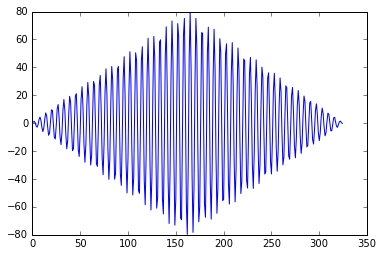

In [3]:
y_scipy = fftconvolve(x1, x2)
plt.plot(y_scipy)

In [4]:
# zero-pad to shape
# half_pad = (shape - x1.shape[-1]) // 2
# xx1 = np.concatenate((np.zeros(half_pad), x1, np.zeros(shape - x1.shape[-1] - half_pad)))
# xx2 = np.concatenate((np.zeros(half_pad), x2, np.zeros(shape - x2.shape[-1] - half_pad)))

pad = shape - x1.shape[-1]
xx1 = np.concatenate((x1, np.zeros(pad)))
xx2 = np.concatenate((x2, np.zeros(pad)))

In [5]:
x1_gpu = gpuarray.to_gpu(xx1.astype(np.float32))
x2_gpu = gpuarray.to_gpu(xx2.astype(np.float32))

# N/2+1 non-redundant FFT coefficients
f1_gpu = gpuarray.empty(xx1.shape[-1] // 2 + 1, np.complex64)
f2_gpu = gpuarray.empty(xx2.shape[-1] // 2 + 1, np.complex64)


plan_fft = cu_fft.Plan(x1_gpu.shape, np.float32, np.complex64)
cu_fft.fft(x1_gpu, f1_gpu, plan_fft)
cu_fft.fft(x2_gpu, f2_gpu, plan_fft)

In [6]:
y_gpu = gpuarray.empty(shape, np.float32)
plan_ifft = cu_fft.Plan(shape, np.complex64, np.float32)
cu_fft.ifft(f1_gpu * f2_gpu, y_gpu, plan_ifft)

True

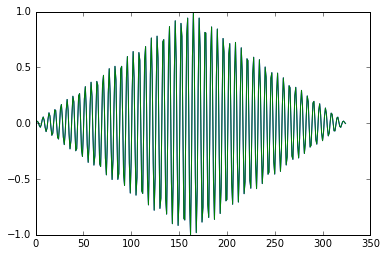

In [7]:
y_cpu = y_gpu.get()
plt.plot(y_cpu / y_cpu.max())
plt.plot(y_scipy / y_scipy.max())
np.allclose(y_cpu / y_cpu.max(), y_scipy / y_scipy.max(), atol=1e-6)

In [10]:
y_scipy.max()

79.823782355991355

In [11]:
y_cpu.max()

25942.723

In [8]:
y_scipy / y_scipy.max()

array([ -1.18685220e-16,   1.05416075e-02,   1.70869646e-02,
         3.53578856e-03,  -2.37022875e-02,  -3.60390442e-02,
        -1.22514145e-02,   3.29218476e-02,   5.57742565e-02,
         2.58142669e-02,  -3.74840182e-02,  -7.51648326e-02,
        -4.36927926e-02,   3.68457767e-02,   9.30744566e-02,
         6.51723405e-02,  -3.06572568e-02,  -1.08395984e-01,
        -8.93766072e-02,   1.87760095e-02,   1.20088586e-01,
         1.15294111e-01,  -1.27518459e-03,  -1.27213276e-01,
        -1.41808985e-01,  -2.15546382e-02,   1.28965814e-01,
         1.67735261e-01,   4.92100702e-02,  -1.24706046e-01,
        -1.91853727e-01,  -8.09859184e-02,   1.13982825e-01,
         2.12950340e-01,   1.15992336e-01,  -9.65537816e-02,
        -2.29855167e-01,  -1.53177714e-01,   7.23993165e-02,
         2.41480761e-01,   1.91356753e-01,  -4.17303709e-02,
        -2.46858927e-01,  -2.29243013e-01,   4.98965726e-03,
         2.45174815e-01,   2.65485117e-01,   3.71537762e-02,
        -2.35797386e-01,

In [9]:
y_cpu / y_cpu.max()

array([  4.70537778e-08,   1.05417436e-02,   1.70870610e-02,
         3.53581761e-03,  -2.37023756e-02,  -3.60390842e-02,
        -1.22515056e-02,   3.29219326e-02,   5.57742789e-02,
         2.58143302e-02,  -3.74840312e-02,  -7.51648992e-02,
        -4.36928831e-02,   3.68457995e-02,   9.30744708e-02,
         6.51724488e-02,  -3.06571890e-02,  -1.08395964e-01,
        -8.93766358e-02,   1.87759418e-02,   1.20088637e-01,
         1.15294196e-01,  -1.27517141e-03,  -1.27213299e-01,
        -1.41809151e-01,  -2.15547476e-02,   1.28965855e-01,
         1.67735264e-01,   4.92101386e-02,  -1.24706067e-01,
        -1.91853881e-01,  -8.09859708e-02,   1.13982826e-01,
         2.12950513e-01,   1.15992360e-01,  -9.65537503e-02,
        -2.29855150e-01,  -1.53177813e-01,   7.23993257e-02,
         2.41480872e-01,   1.91356778e-01,  -4.17304114e-02,
        -2.46858969e-01,  -2.29243070e-01,   4.98959422e-03,
         2.45174825e-01,   2.65485197e-01,   3.71537395e-02,
        -2.35797435e-01,